### Classification of Disaster Tweets using Natural Language Processing

* This project is based on a classification problem and its major goal is to classify a input tweet into either category i.e.
    * **Disaster Tweet**, represented by 1 in our datasets or
    * **Non-Disaster Tweet**, represented by 0 i our datasets.

* For this project we are provided with 2 historical datasets i.e
    * The labeled Data set , named as **df_train** in our notebook and
    * The unlabelled Data set , named as **df_test** in our notebook.
    
* The goal of the project is to train a binary classifier model so as to attain high accuracy for prediction and therefore, label the unlabelled data **df_test**. 

* To achieve this we will be using different Machine learning techniques and algorithms alongwith NLP (Natural Language Processing) and, also test and compare multiple classification models for their prediction accuracies.

* In conclusion, this project helps in grouping tweets which further helps in identifying the actual disastes tweets among a heap of tweets.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud,STOPWORDS  # for meta features and cleaning purpose
import string  # for meta features
from collections import defaultdict   # for analysing and visualising n-grmas
from nltk.stem import WordNetLemmatizer # for text cleaning

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print("\n% Null values in Train set\n")
(df_train.isnull().sum()/len(df_train))*100


% Null values in Train set



id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [7]:
print("\n% Null values in Test set\n")
(df_test.isnull().sum()/len(df_test))*100


% Null values in Test set



id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

In [8]:
df_test[['keyword','location']].isnull().sum()

keyword       26
location    1105
dtype: int64

## Plotting missing value counts for each set

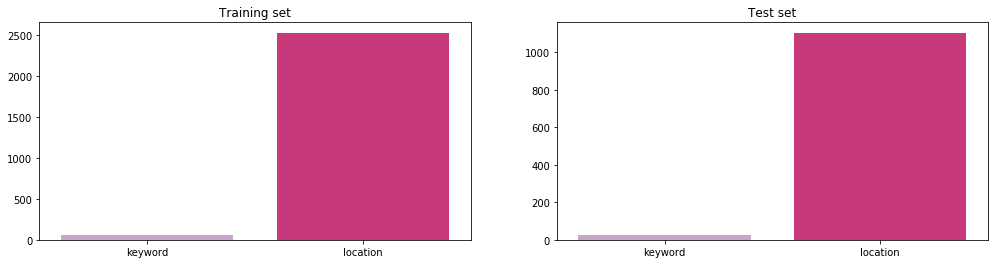

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4))

sns.barplot( df_train[['keyword','location']].isnull().sum().index, df_train[['keyword','location']].isnull().sum().values,ax =axes[0],palette='PuRd')
sns.barplot( df_test[['keyword','location']].isnull().sum().index, df_test[['keyword','location']].isnull().sum().values,ax= axes[1],palette='PuRd')

axes[0].set_title("Training set")
axes[1].set_title("Test set")

plt.show()

We can see thst the ratio of missing data is very close.<br>
Also as the keyords missing are very low we can replace the nulls with no_keyword and same can be done for location

In [10]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

<h3>Unique value counts in <b>Keyword</b> and <b>Location</b> 


In [11]:
train_key_count = df_train["keyword"].nunique()
test_key_count = df_test["keyword"].nunique()

train_loc_count = df_train["location"].nunique()
test_loc_count = df_test["location"].nunique()

print(f"The number of unique values for the column 'keyword' is = {train_key_count} (Training set) and {test_key_count} (Test set)")
print(f"The number of unique values for the column 'keyword' is = {train_loc_count} (Training set) and {test_loc_count} (Test set)")

The number of unique values for the column 'keyword' is = 222 (Training set) and 222 (Test set)
The number of unique values for the column 'keyword' is = 3342 (Training set) and 1603 (Test set)


Here, we can see that there exist no much common words in the column 'location', hence can be dropped as a feature for the classification problem.
So, the column 'keyword' becomes one of the major column in class prediction and is to be used as a feature for the model.

# Target Keyword Distribution

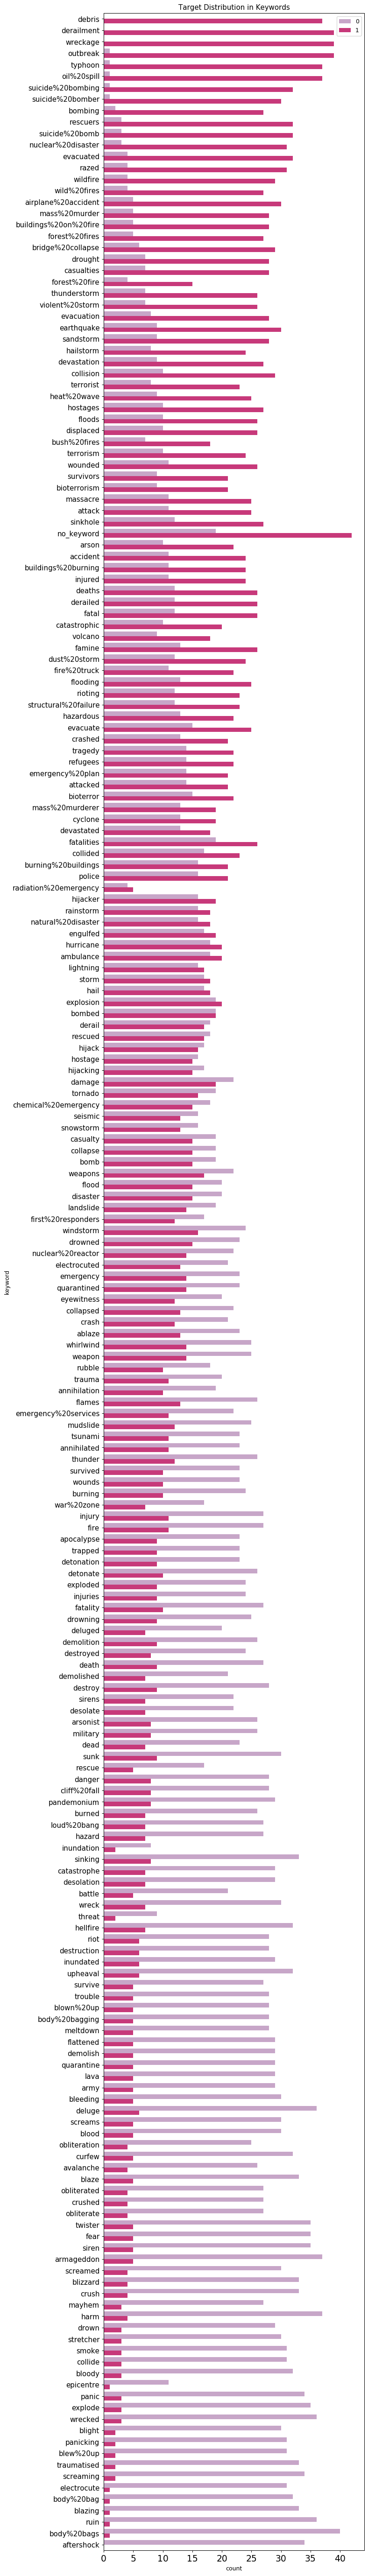

In [12]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
# this new column is only meant for plotting the data and is to be droped after plotting

fig = plt.figure(figsize=(8,80),dpi =90)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'] , palette="PuRd")

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Here, in this plot we can see how the a keyword is related to the target.

# Meta Features

Distributions of meta features in the given datasets can be helpful to identify disaster tweets. <br>It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. <br>Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text

In [13]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


Now we will plot the above collected meta features of the training and test set

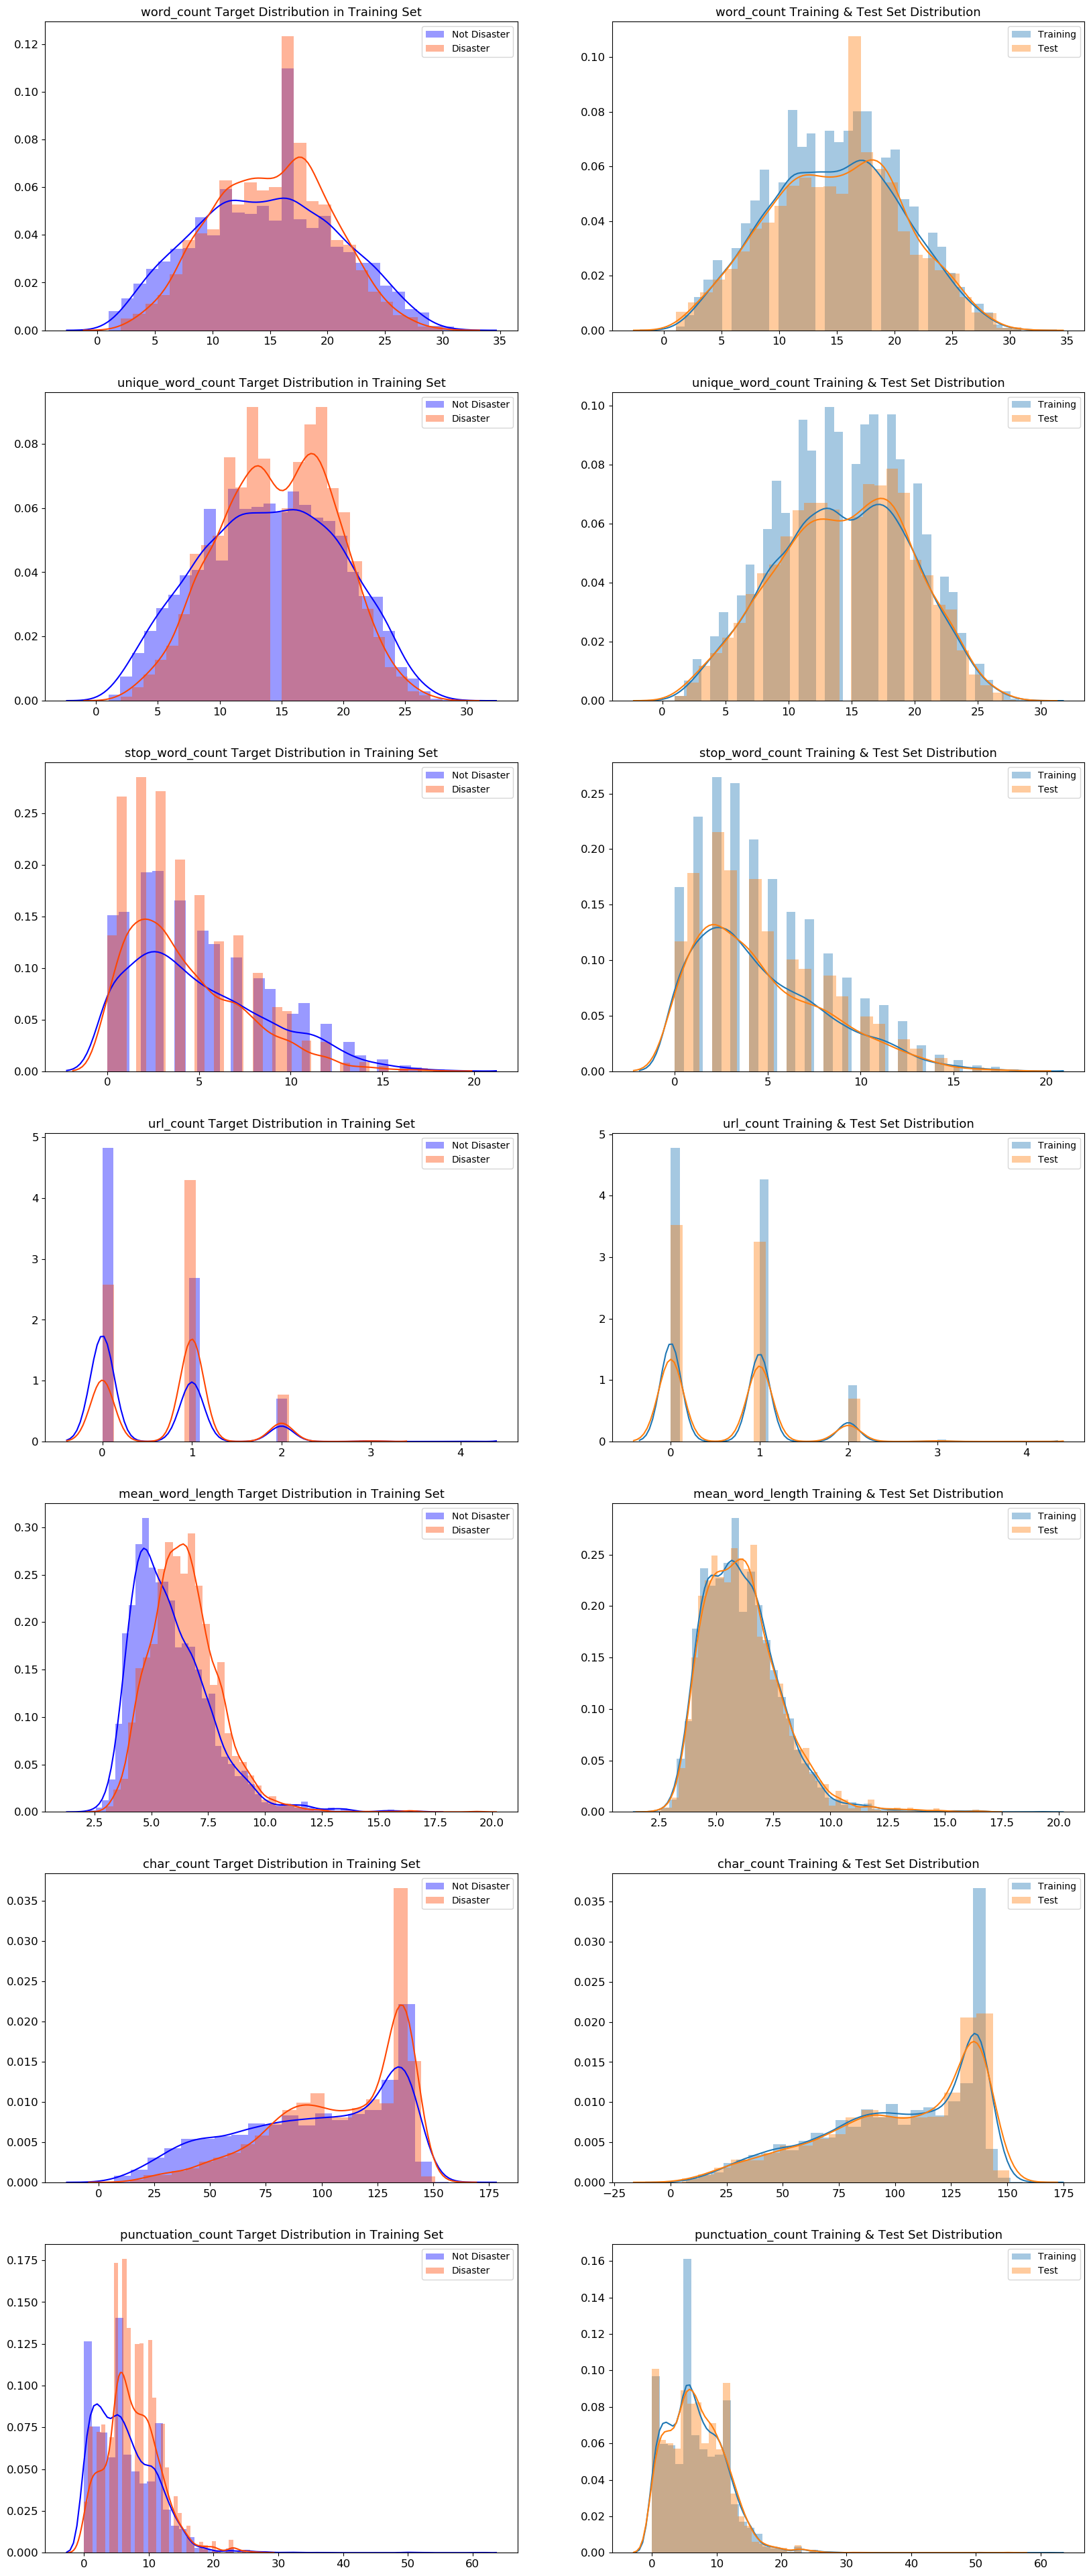

In [14]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='blue')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='orangered')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

The above plots show that meta features have very similar distributions over the training and test set as the graphs nearly overlap which also concludes that the training and test samples are seperated for a single sample.

Here we also observer that, the meta features have information about target as well, but one of them is not good enough such as `url_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

##  Target and N-grams

The %age contribution of target classes in the training set can be calculated as bellow.

In [15]:
count_df = df_train.groupby(['target']).count()

print(f"Class Not Disaster contributes :{round((count_df['id'][0]/count_df['id'].sum())*100,2)} %, in the training dataset ")
print(f"Class Disaster contributes :{round((count_df['id'][1]/count_df['id'].sum())*100,2)} %, in the training dataset ")

del count_df

Class Not Disaster contributes :57.03 %, in the training dataset 
Class Disaster contributes :42.97 %, in the training dataset 


Class distributions are 57.03% for 0 (Not Disaster) and 42.97% for 1 (Disaster) and we can say that the classes are almost equally separated.

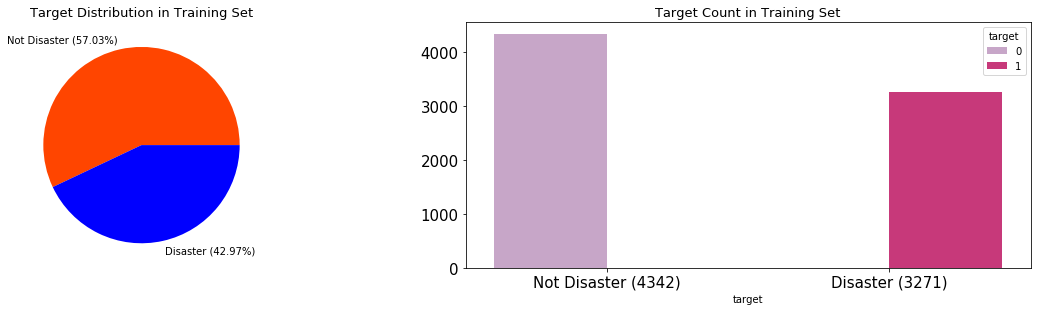

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4))
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57.03%)', 'Disaster (42.97%)'],colors = ['orangered','blue'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1] , palette="PuRd")

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [17]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100  # the number of n-grams we want to plot

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

### **Unigrams**

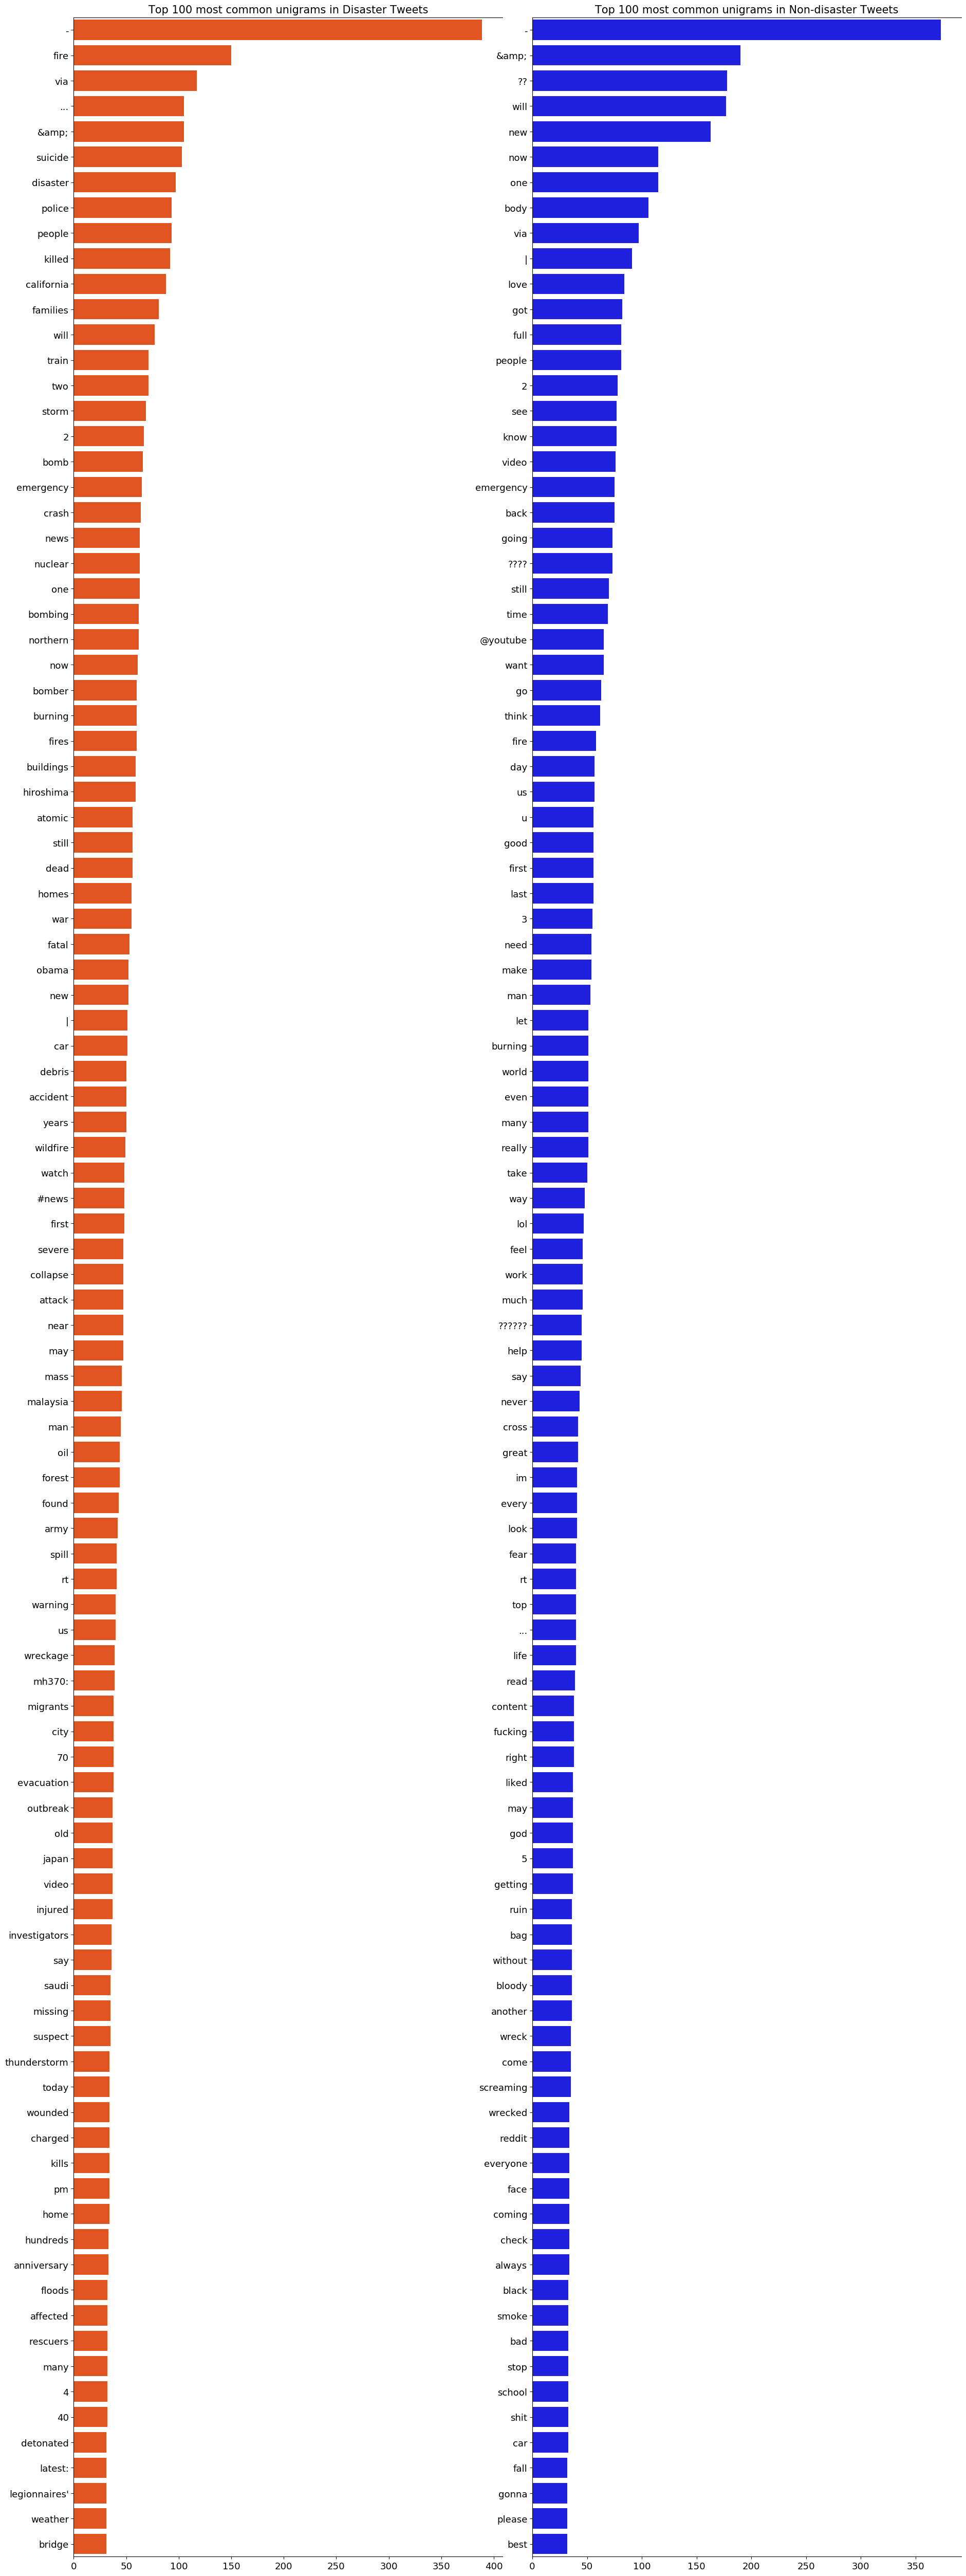

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='orangered')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

###  Bigrams

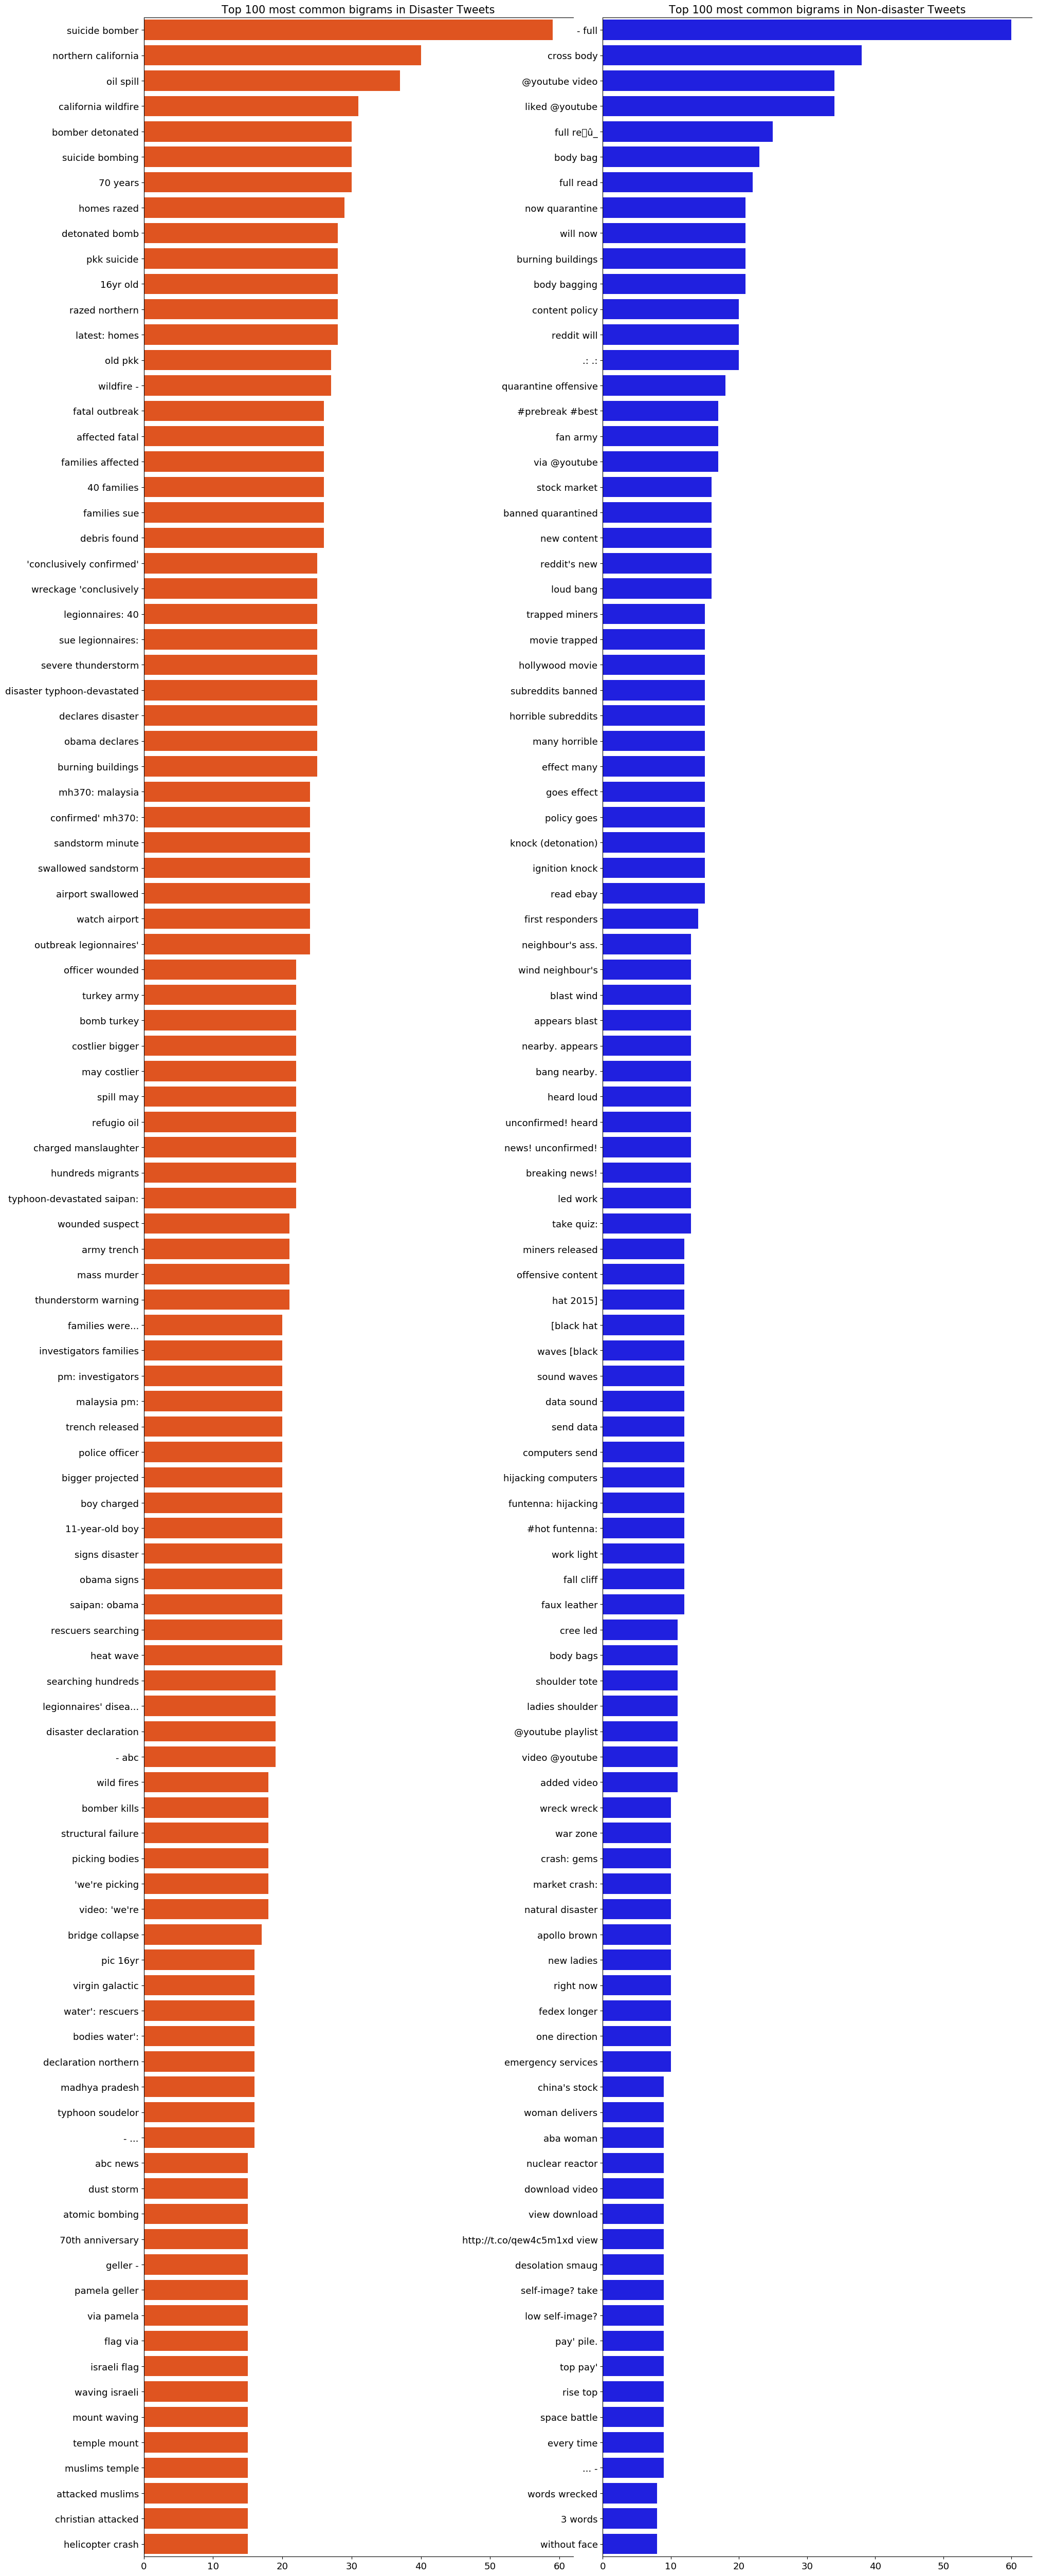

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='orangered')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

There are no common bigrams exist in **both classes**  because the context is clearer.

Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

### **Trigrams**

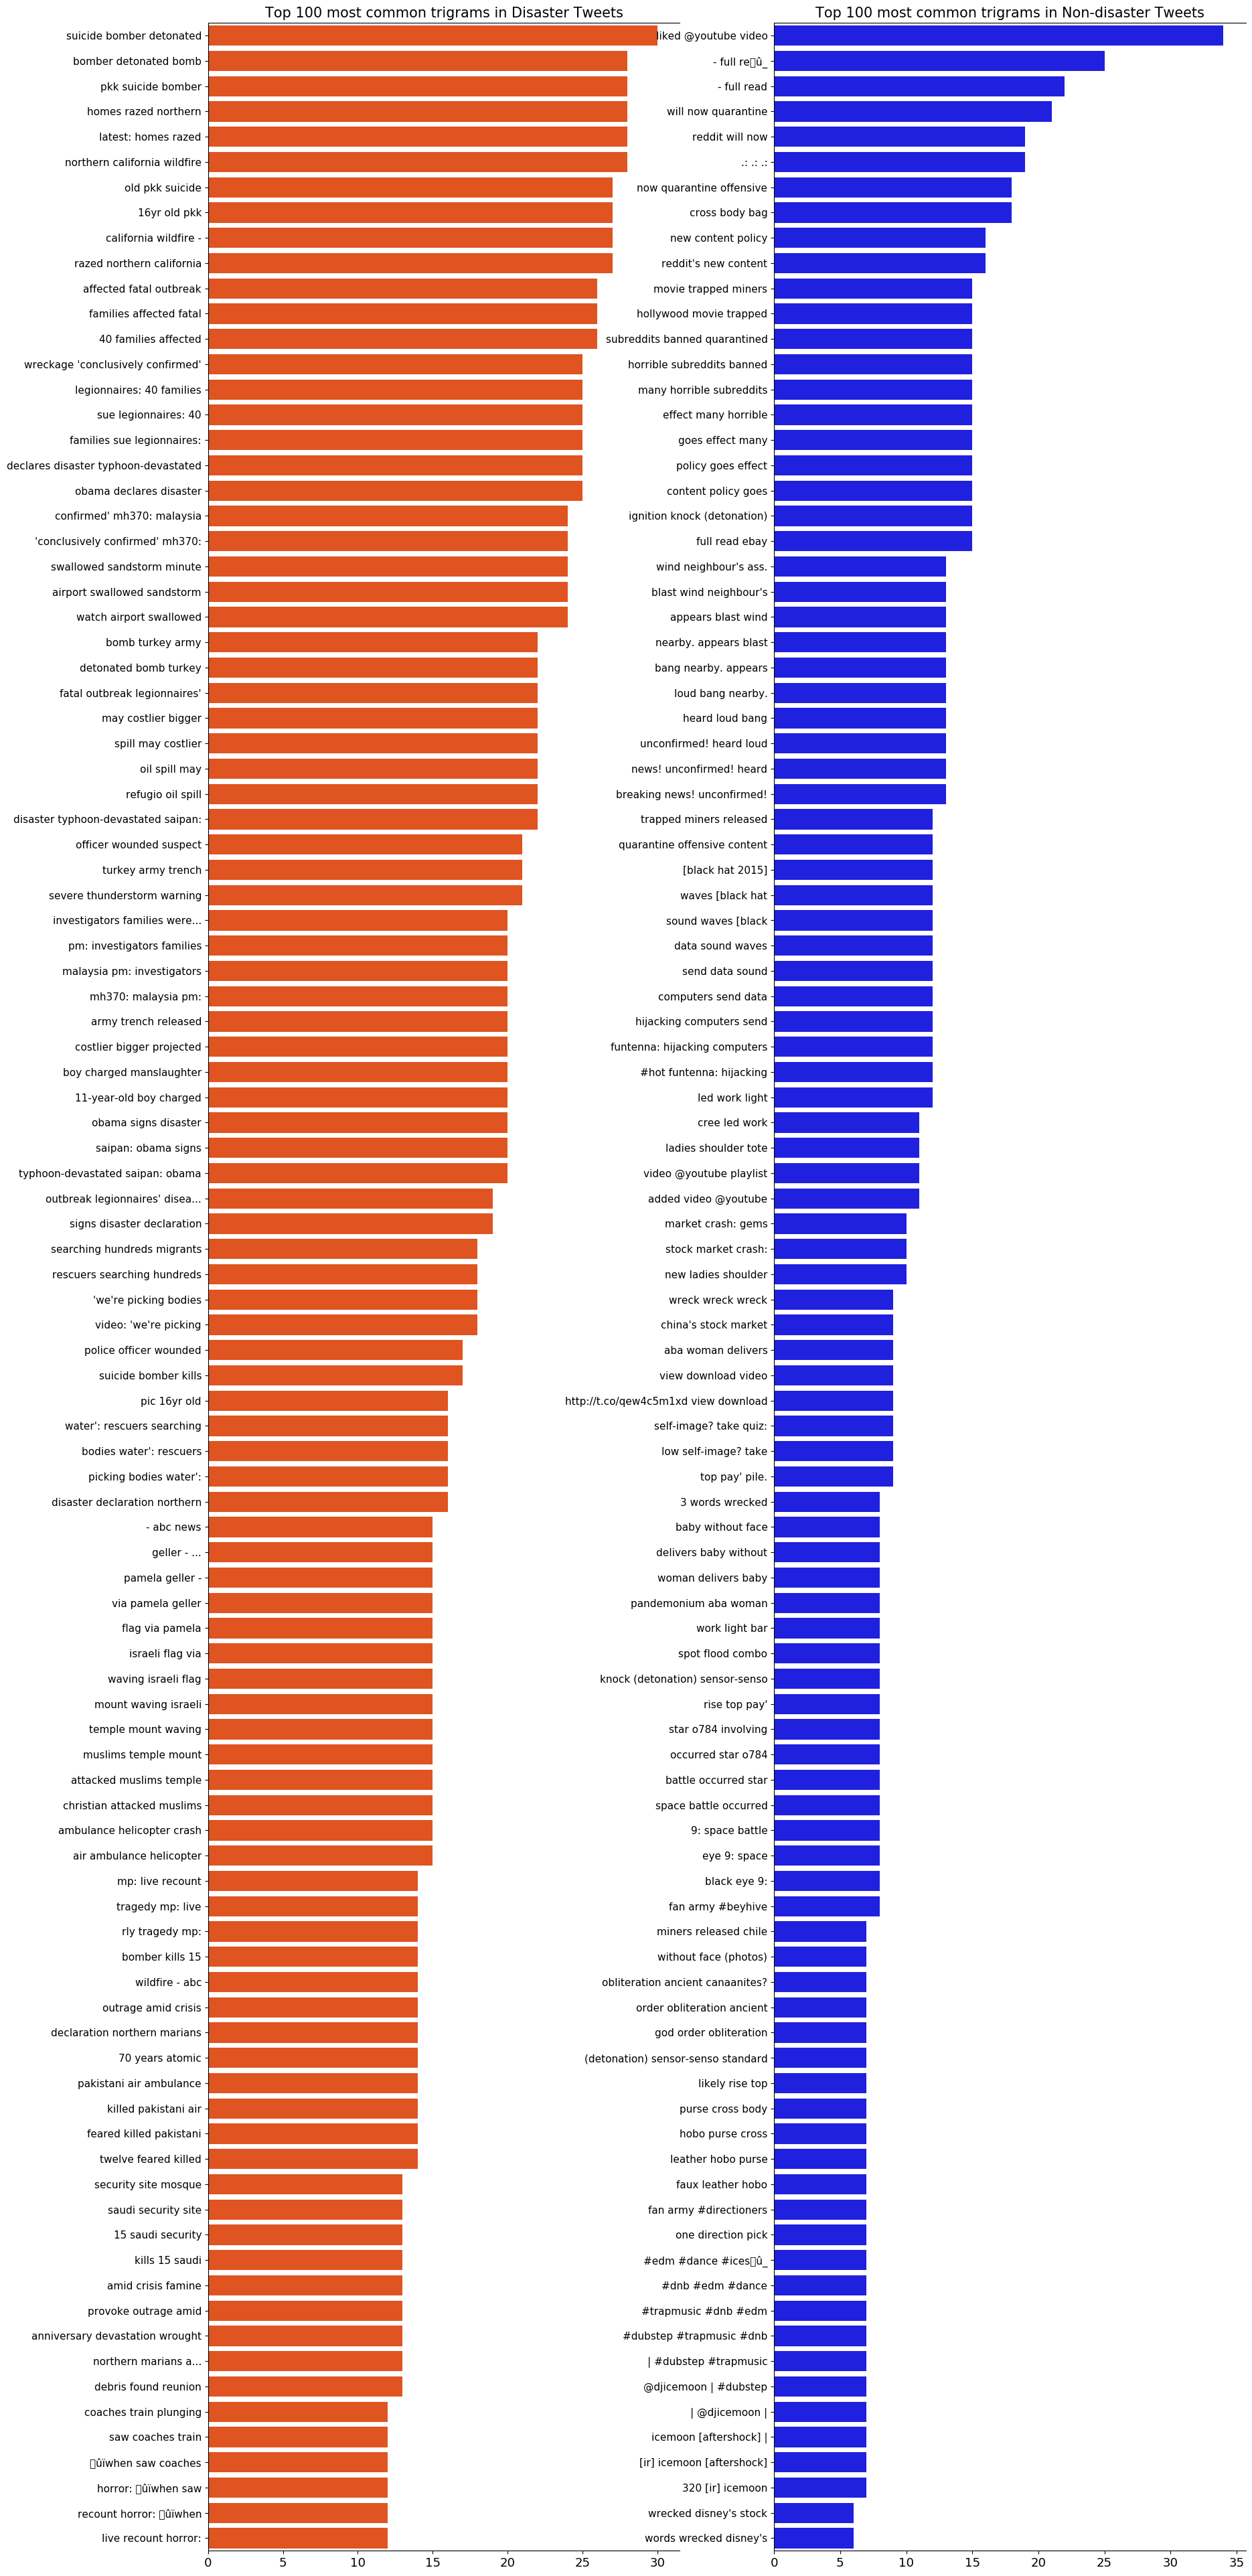

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='orangered')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

There are no common trigrams exist in **both classes**  because the context is clearer.

Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

# Text Cleaning

For cleaning the historical tweet data we attain we need to build a function.<br>
One of the major responsibilites of the function is to remove the noise from the text data(@user, characters not able to encode/decode properly) which may <br>
* Remove stop words
* Remove punctuations 
* Remove special characters
* Remove hyperlinks and other noises.

In [21]:
stopword = set(STOPWORDS)

In [22]:
def cleanText(df , text_col , new_col = "clean_text", lemmatization = True):
    
    clean_df = df.copy()  # we make a copy of the original data so as to avoid changes in the main data-frame
    
    clean_df[new_col] = clean_df[text_col]
    
    #removing urls from the text
    clean_df[new_col] =  clean_df[new_col].map(lambda x: re.sub('https?:\/\/[a-zA-z0-9\.\/]+' , '' ,str(x)))
    
    # removing @user_ids 
    clean_df[new_col] = clean_df[new_col].apply(lambda x: re.sub(('@[a-zA-z0-9_]+') , '' , str(x)))
    
    #removing &ampersand
    clean_df[new_col] =  clean_df[new_col].map(lambda x: re.sub("&amp" , '' , str(x)))
    
    # converting all the text to lower case
    clean_df[new_col] = clean_df[new_col].str.lower()
    
    # treating special characters
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\’", "\'", str(x)))  
                                                                    # replacing the quotation mark with a inverted comma
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r'[?|!|\'|"|#]', r"", str(x)))
                                                                    # removing terminating characters
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r'[.|,|)|(|\|/]', r" ", str(x)))
                                                                    # replacing characters seperating two words with a white space
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\r", "", str(x)))
                                                                    # removing carriage return character
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\n", "", str(x)))
                                                                    # pusing the content to a single line
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\s\'", " ", str(x)))
                                                                    # replacing ( ') with white space e.g. father 's becomes father s
    
    # removing some well known contractions
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"shouldn\'t", "should not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"shouldnt", "should not", str(x)))

    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"wouldn\'t", "would not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"wouldnt", "would not", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"wont", "will not", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"cant", "can not", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"dont", "do not", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'s", " is", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'m", " am", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'r", " are", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\’t", " not", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'t", " not", str(x)))
    
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'ll", " will", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'d", " would", str(x)))
    clean_df[new_col] = clean_df[new_col].map(lambda x: re.sub(r"\'ve", " have", str(x)))
    
    # trimming sentences
    '''
    e.g. the string-> s = "Heard about #earthquake is different cities, stay safe everyone."
    becomes -> s = "Heard about earthquake is different cities stay safe everyone"
    i.e. every remaining special character has been removed
    
    '''
    clean_df[new_col] = clean_df[new_col].str.strip() 
    clean_df[new_col] = clean_df[new_col].apply(lambda x : re.findall("[A-Za-z0-9]+", x))
    clean_df[new_col] = clean_df[new_col].apply(lambda x : " ".join(x))
    
    # removing stopwords
    clean_df[new_col] = clean_df[new_col].apply(lambda x: ['' if word in stopword else word for word in x.split()])
    clean_df[new_col] = clean_df[new_col].apply(lambda x : " ".join(x))
    
    #lemmatization
    if lemmatization:
        
        lemma = WordNetLemmatizer()
        
        clean_df[new_col] = clean_df[new_col].apply(lambda sentence : [lemma.lemmatize(word,'v') for word in sentence.split(" ")])
        
        clean_df[new_col] = clean_df[new_col].apply(lambda x : " ".join(x))
        
    return clean_df

<b>Concatinating the train and test dataset<br> 
</b><br>This is to be done for cleaning and vectorisation purpose

In [23]:
concatenated_df = pd.concat([df_train, df_test], axis=0, sort=False, ignore_index=True)
concatenated_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1.0,13,13,6,0,4.384615,69,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1.0,7,7,0,0,4.571429,38,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1.0,22,20,11,0,5.090909,133,3
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1.0,8,8,1,0,7.125000,65,2
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1.0,16,15,7,0,4.500000,88,2


In [24]:
train_df = cleanText(concatenated_df,'text')
clean_train = cleanText(df_train,'text')
clean_test = cleanText(df_test ,'text')

In [25]:
#train_df.to_csv("Clean_tweet_data.csv")

# Plotting the word cloud

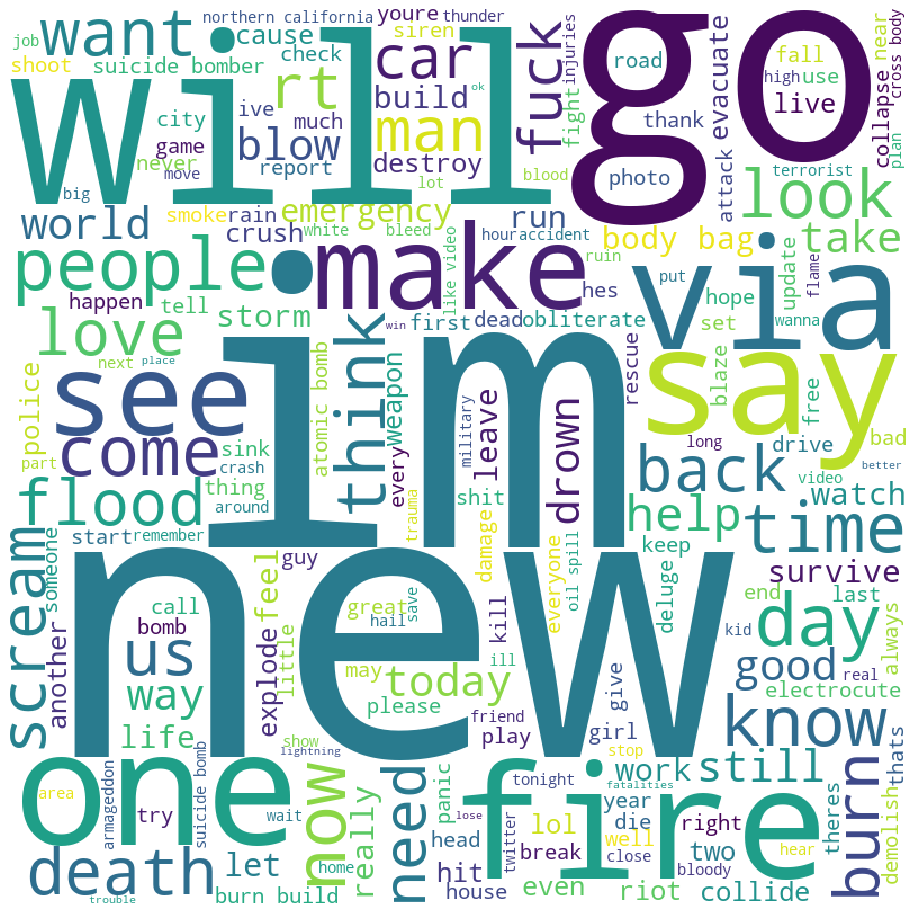

In [26]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10)
wordcloud.generate(" ".join(clean_train['clean_text']))
# plot the WordCloud image                        
plt.figure(figsize = (10, 12), facecolor = None, dpi=90) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

#### Wordcloud for overall data set in the "concatenated_df"

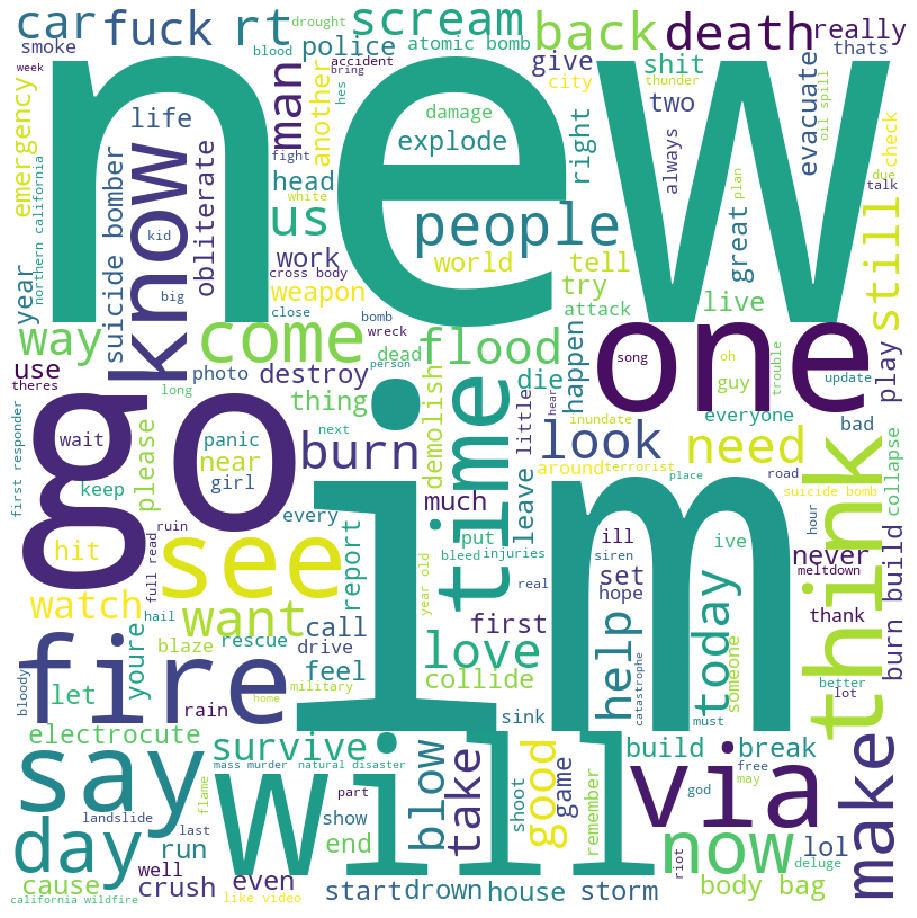

In [27]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10)
wordcloud.generate(" ".join(train_df['clean_text']))
# plot the WordCloud image                        
plt.figure(figsize = (10, 12), facecolor = None, dpi=90) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

Here we can see that  <font size = 14><b>Fire </b></font>seems to be one of the major issues in the in both the word clouds.

### Preparing data using TF-IDF [Term Frequency Inverse Document Matrix]

In [28]:
vec = TfidfVectorizer(ngram_range=(1,5),
                      #max_features=10000,
                      min_df=3,
                      stop_words='english')

tfidf_matrix = vec.fit_transform(train_df['clean_text'])

In [29]:
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
                            columns = vec.get_feature_names(),
                            dtype='float32')

print("Shape of the dataframe ",tfidf_matrix.shape)
print('Data Frame Info')
tfidf_matrix.info()

Shape of the dataframe  (10876, 13157)
Data Frame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Columns: 13157 entries, 00 to zouma flatten
dtypes: float32(13157)
memory usage: 545.9 MB


## Preparing data for training

In [30]:
X = tfidf_matrix.iloc[range(0, df_train.shape[0]), :]

test_dataset = tfidf_matrix.iloc[df_train.shape[0]:, :]  

y = concatenated_df.loc[0:df_train.shape[0]-1, 'target']

In [31]:
x_train,x_test,y_train,y_test  = train_test_split(X, y,test_size=0.17,random_state = 269)

# Model training for prediction

## 1. Logistic regression Model

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
log_model_f1 = f1_score(y_test, log_model.predict(x_test))
log_model_accuracy = accuracy_score(y_test,log_model.predict(x_test))
                        
print("F1 Score is ", log_model_f1 )
print("Accuracy of the model is ", log_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, log_model.predict(x_test))

F1 Score is  0.7633434038267876
Accuracy of the model is  0.8185328185328186

----------Confusion Matrix----------


array([[681,  69],
       [166, 379]], dtype=int64)

## 2. Naive Bayes Multinomial Model

In [35]:
from sklearn.naive_bayes import MultinomialNB

In [36]:
multinom_model = MultinomialNB()
multinom_model.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
multinom_model_f1 = f1_score(y_test, multinom_model.predict(x_test))
multinom_model_accuracy = accuracy_score(y_test,multinom_model.predict(x_test))
                        
print("F1 Score is ", multinom_model_f1 )
print("Accuracy of the model is ", multinom_model_accuracy)
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, multinom_model.predict(x_test))

F1 Score is  0.7349137931034483
Accuracy of the model is  0.81003861003861

----------Confusion Matrix----------


array([[708,  42],
       [204, 341]], dtype=int64)

## 3. Naive Bayes Gaussian Model

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
gaussian_model = GaussianNB()
gaussian_model.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [40]:
gaussian_model_f1 = f1_score(y_test, gaussian_model.predict(x_test))
gaussian_model_accuracy = accuracy_score(y_test,gaussian_model.predict(x_test))
                        
print("F1 Score is ", gaussian_model_f1 )
print("Accuracy of the model is ", gaussian_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, gaussian_model.predict(x_test))

F1 Score is  0.6631467793030623
Accuracy of the model is  0.7536679536679537

----------Confusion Matrix----------


array([[662,  88],
       [231, 314]], dtype=int64)

## 4. Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
rf_model_f1 = f1_score(y_test, rf_model.predict(x_test))
rf_model_accuracy = accuracy_score(y_test,rf_model.predict(x_test))
                        
print("F1 Score is ", rf_model_f1 )
print("Accuracy of the model is ", rf_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, rf_model.predict(x_test))

F1 Score is  0.7384305835010061
Accuracy of the model is  0.7992277992277992

----------Confusion Matrix----------


array([[668,  82],
       [178, 367]], dtype=int64)

## 5. Support Vector Machine

In [44]:
from sklearn.svm import SVC

In [45]:
sv_model = SVC(kernel='rbf',gamma=10)
sv_model.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
sv_model_f1 = f1_score(y_test, sv_model.predict(x_test))
sv_model_accuracy = accuracy_score(y_test,sv_model.predict(x_test))
                        
print("F1 Score is ", sv_model_f1 )
print("Accuracy of the model is ", sv_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, sv_model.predict(x_test))

F1 Score is  0.4182076813655761
Accuracy of the model is  0.6841698841698842

----------Confusion Matrix----------


array([[739,  11],
       [398, 147]], dtype=int64)

## 6. XG Boost Classifier

In [47]:
from xgboost import XGBClassifier

In [48]:
xgbc_model = XGBClassifier(max_depth=6,
                    learning_rate=0.3,
                    n_estimators=1500,
                    objective='binary:logistic',
                    random_state=72,
                    n_jobs=4)

xgbc_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=72,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
xgbc_model_f1 = f1_score(y_test, xgbc_model.predict(x_test))
xgbc_model_accuracy = accuracy_score(y_test,xgbc_model.predict(x_test))
                        
print("F1 Score is ", xgbc_model_f1 )
print("Accuracy of the model is ", xgbc_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, xgbc_model.predict(x_test))

F1 Score is  0.7370441458733206
Accuracy of the model is  0.7884169884169884

----------Confusion Matrix----------


array([[637, 113],
       [161, 384]], dtype=int64)

 ## 7. Ada Boost Classifier

In [50]:
from sklearn.ensemble import AdaBoostClassifier

In [51]:
abc_model = AdaBoostClassifier(n_estimators = 800,
                               random_state= 263)

abc_model.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=800, random_state=263)

In [52]:
abc_model_f1 = f1_score(y_test, abc_model.predict(x_test))
abc_model_accuracy = accuracy_score(y_test,abc_model.predict(x_test))
                        
print("F1 Score is ", abc_model_f1 )
print("Accuracy of the model is ", abc_model_accuracy )
print("\n----------Confusion Matrix----------")
confusion_matrix(y_test, abc_model.predict(x_test))

F1 Score is  0.7102983638113571
Accuracy of the model is  0.7675675675675676

----------Confusion Matrix----------


array([[625, 125],
       [176, 369]], dtype=int64)

### Comparing Accuracies and F-1 Score of different models

In [53]:
model_list = ['SVM', 'Log.\nRegression', 'Random Forest', 'Naive Bayes\nMultinomial\nClassifier'
             , 'Naive Bayes\nGaussian\nClassifier', 'XG Boost\nClassifier', 'Ada Boosting\nClassifier']

f1_score_list = [sv_model_f1, log_model_f1, rf_model_f1, multinom_model_f1
                , gaussian_model_f1, xgbc_model_f1, abc_model_f1]

accuracy_list = [sv_model_accuracy, log_model_accuracy, rf_model_accuracy, multinom_model_accuracy
                , gaussian_model_accuracy, xgbc_model_accuracy, abc_model_accuracy]

<b> Combining the list to make a <font size = 4.85>"Key:Value"</font> pair so as to plot respectively sorted data.

In [54]:
f1_score_dict = dict(zip(model_list, f1_score_list))
accuracy_dict = dict(zip(model_list, accuracy_list))

In [55]:
# Sorting and storing the the iterables to respective variables for plotting

f1_plot_x , f1_plot_y = zip(*sorted(f1_score_dict.items(), key = lambda x : x[1]))

#Simillarly for the accuraaccuracy_dict

acc_plot_x , acc_plot_y = zip(*sorted(accuracy_dict.items(), key = lambda x : x[1]))

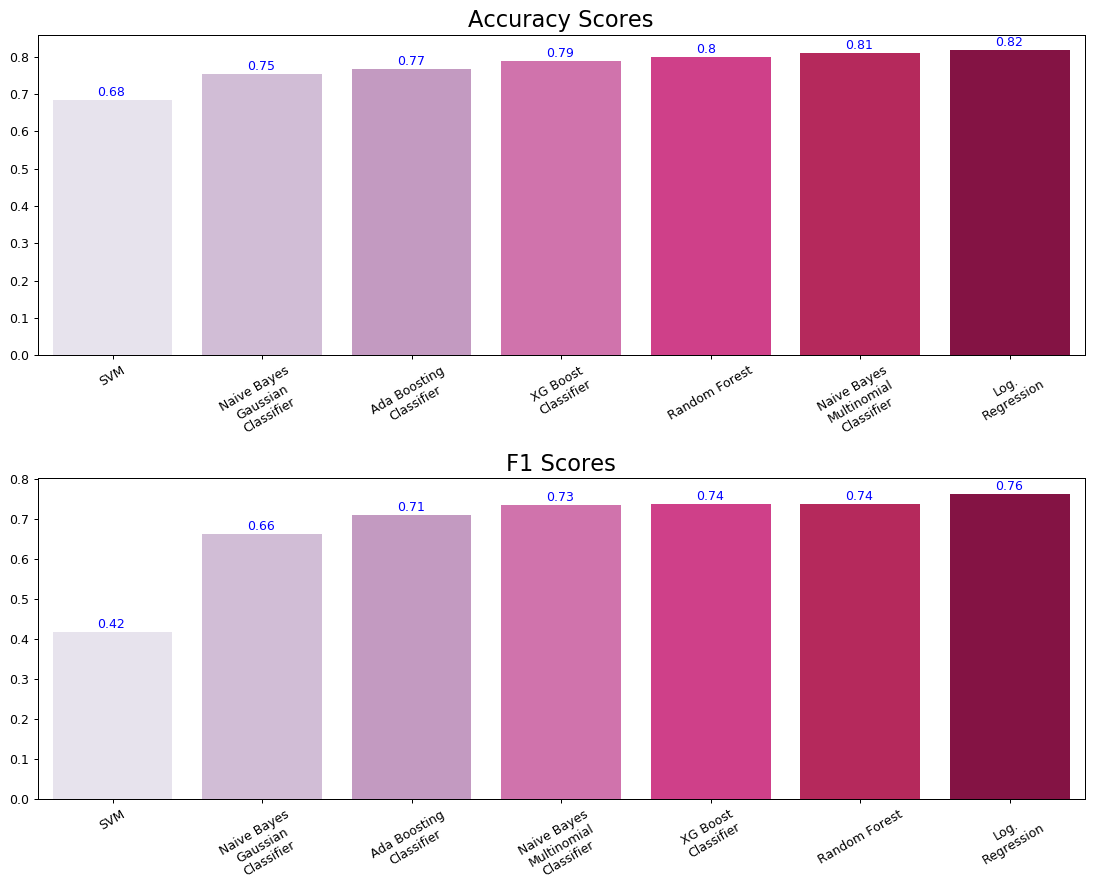

In [56]:
fig, axes = plt.subplots(ncols= 2, nrows=2, figsize=(24, 10),dpi=90)


sns.barplot(list(acc_plot_x) , acc_plot_y, ax= axes[0, 0], palette="PuRd")
sns.barplot(list(f1_plot_x) , f1_plot_y, ax =axes[1, 0], palette="PuRd")

fig.delaxes(axes[0 ,1])
fig.delaxes(axes[1 ,1])

for i, v in enumerate(acc_plot_y):
    axes[0, 0].text(i-0.1 , v+0.01,  str(round(v,2)), color='blue')
    
for i, v in enumerate(f1_plot_y):
    axes[1, 0].text(i-0.1 , v+0.01,  str(round(v,2)), color='blue')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30)
    
axes[0, 0].set_title("Accuracy Scores" ,size =18)
axes[1, 0].set_title("F1 Scores",size =18)

fig.tight_layout(pad=1.0)
plt.show()

## Conclusion
 After analysing the plots above we can say that among all 7 classifiers i.e <b> SVM, Random Forest, NB GAussian Model, NB Multionmial Model, Ada Boost classifier, XG Boost classifier and Logistic regression </b>, <b><font size =4.5>Logistic regression</font></b> out performs every single one with an accuracy score of <b><font size =4.5>81.8532 %</font></b><br>
<br>Hence, we can further use this logistic regression model to predict the outcome of our Test set i.e named as <b> test_df</b> in this notebook.

# Prediction of Output

In [57]:
test_dataset.head()

,00,00 11,00 11 16,00 11 16 utc2015,00 11 16 utc2015 08,00 pm,000,000 riot,000 riot point,01,...,zipper,zombie,zombie apocalypse,zone,zone come,zone come soon,zone come soon artistsunited,zone war,zouma,zouma flatten
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
clean_test.head()

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,clean_text
0,0,no_keyword,no_location,Just happened a terrible car crash,6,6,2,0,4.833333,34,0,happen terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s...",9,9,2,0,6.222222,64,3,hear earthquake different cities stay safe e...
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are...",19,19,10,0,4.105263,96,2,forest fire spot pond geese flee across ...
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,9.250000,40,3,apocalypse light spokane wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45,0,typhoon soudelor kill 28 china taiwan


In [59]:
target = log_model.predict(test_dataset)

In [60]:
target = target.astype(int)

In [61]:
submission_dataset = pd.DataFrame(data = {'id': clean_test['id'],"target" : target})
submission_dataset.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [62]:
#submission_dataset.to_csv("Predicted tweets set.csv")